# Import Required Libraries

In [1]:
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# To import overbalanced data
from scipy.sparse import load_npz

# Data balancing
from imblearn.over_sampling import SMOTE

# Sklearn libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
)

# NLTK libraries
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
import contractions

# NLTK resource downloads
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('maxent_ne_chunker')


from textblob import TextBlob

[nltk_data] Downloading package words to C:\Users\Aaron
[nltk_data]     Liew\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Aaron
[nltk_data]     Liew\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Aaron
[nltk_data]     Liew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Aaron
[nltk_data]     Liew\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to C:\Users\Aaron
[nltk_data]     Liew\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


# Load in Datasets


In [2]:
def load_file(filepath):
    return pd.read_csv(filepath, header=None)

In [4]:
# Training df
df_train = load_file('raw_data/fulltrain.csv')
df_train = df_train.set_axis(['label', 'text'], axis=1)

# Testing df
df_test = load_file('raw_data/balancedtest.csv')
df_test = df_test.set_axis(['label', 'text'], axis=1)

# Map the labels

In [5]:
label_mapping = {
    1: "Satire",
    2: "Hoax",
    3: "Propaganda",
    4: "Reliable News"
}
df_train['label'] = df_train['label'].map(label_mapping)
df_test['label'] = df_test['label'].map(label_mapping)

# Verify datasets loaded in correctly

In [6]:
df_train.head(10) # Training set

,label,text
0,Satire,"A little less than a decade ago, hockey fans w..."
1,Satire,The writers of the HBO series The Sopranos too...
2,Satire,Despite claims from the TV news outlet to offe...
3,Satire,After receiving 'subpar' service and experienc...
4,Satire,After watching his beloved Seattle Mariners pr...
5,Satire,"At a cafeteria-table press conference Monday, ..."
6,Satire,Stunned shock and dismay were just a few of th...
7,Satire,"Speaking with reporters before a game Monday, ..."
8,Satire,Sports journalists and television crews were p...
9,Satire,"SALEM, VAF;or the eighth straight world-histor..."


In [7]:
df_test.head(10) # Test set

,label,text
0,Satire,When so many actors seem content to churn out ...
1,Satire,In what football insiders are calling an unex...
2,Satire,In a freak accident following Game 3 of the N....
3,Satire,North Koreas official news agency announced to...
4,Satire,The former Alaska Governor Sarah Palin would b...
5,Satire,With the first Presidential debate just two da...
6,Satire,"There are fans, and then there are super-fans...."
7,Satire,"With its landmark decisions this week, the Uni..."
8,Satire,Koch Industries is defending its acquisition o...
9,Satire,Republican lawmakers asked increasingly tough ...


# Label distribution

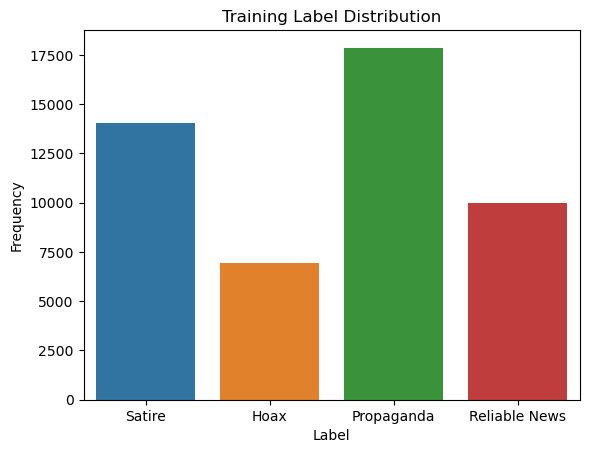

label
Propaganda       17870
Satire           14047
Reliable News     9995
Hoax              6942
Name: count, dtype: int64

In [8]:
sns.countplot(x='label', data=df_train)
plt.title('Training Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
df_train["label"].value_counts()

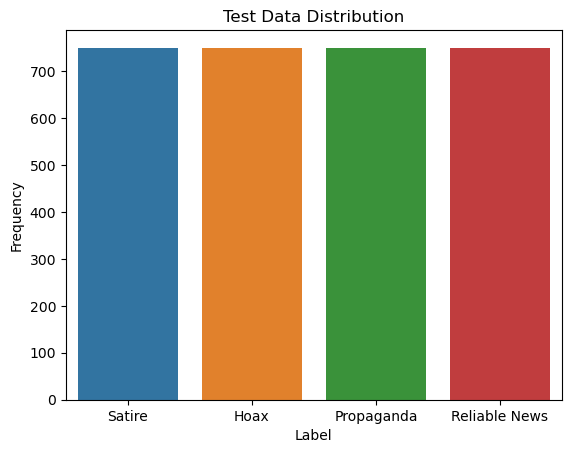

label
Satire           750
Hoax             750
Propaganda       750
Reliable News    750
Name: count, dtype: int64

In [9]:
sns.countplot(x='label', data=df_test)
plt.title('Test Data Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
df_test["label"].value_counts()

# Basic Text Preprocessing

## Expand Contractions

In [10]:
def expand_contractions(corpus):
    return contractions.fix(corpus)

## Removal of Stop Words

In [11]:
def remove_stopwords(corpus):
    stop = nltk.corpus.stopwords.words('english')
    sentence = ""
    for word in corpus.split():
        if word not in stop:
            sentence += word
            sentence += " "
    return sentence.strip()

## Lemmitization with WordNetLemmitizer

In [12]:
def lemmatize_word(corpus):
    lemma = WordNetLemmatizer()
    sentence = ""
    for word in corpus.split():
        sentence += lemma.lemmatize(word)
        sentence += " "
    return sentence.strip()

## Preprocess the text

In [13]:
def preprocess_text(text):
    text_contractions_expanded = expand_contractions(text)
    text_no_stopwords = remove_stopwords(text_contractions_expanded)
    text_processed = lemmatize_word( text_no_stopwords)
    return text_processed

In [14]:
# Processing datasets
print("Processing dataset: df_train")
df_train['processed_text'] = df_train['text'].apply(preprocess_text)
print("Finished processing dataset: df_train")

print("Processing dataset: df_test")
df_test['processed_text'] = df_test['text'].apply(preprocess_text)
print("Finished processing dataset: df_test")

Processing dataset: df_train
Finished processing dataset: df_train
Processing dataset: df_test
Finished processing dataset: df_test


# Feature Engineering

## Word Count

In [111]:
def count_words(text):
    words = word_tokenize(text)
    return len(words)

# Assuming df_train and df_test are already defined and have a column 'processed_text'
df_train['word_count'] = df_train['processed_text'].apply(count_words)
df_test['word_count'] = df_test['processed_text'].apply(count_words)

# Convert DataFrame columns to NumPy arrays
word_count_train = df_train['word_count'].to_numpy()
word_count_test = df_test['word_count'].to_numpy()

# Save the arrays to .npy files
np.save('word_count_train.npy', word_count_train)
np.save('word_count_test.npy', word_count_test)

## Named Entity Recognition

In [112]:
def count_named_entities(corpus):
    count = 0
    tagged_corpus = pos_tag(word_tokenize(corpus))
    named_entities = ne_chunk(tagged_corpus)
    for elem in named_entities:
        if hasattr(elem, 'label'):
            count += 1
    return count

df_train['named_entity_count'] = df_train['processed_text'].apply(count_named_entities)
df_test['named_entity_count'] = df_test['processed_text'].apply(count_named_entities)

# Convert DataFrame columns to NumPy arrays
named_entity_count_train = df_train['named_entity_count'].to_numpy()
named_entity_count_test = df_test['named_entity_count'].to_numpy()

# Save the arrays to .npy files
np.save('named_entity_count_train.npy', named_entity_count_train)
np.save('named_entity_count_test.npy', named_entity_count_test)

## Pronoun counts

In [113]:
def count_pronouns_per_word(text, pronoun_list):
    words = word_tokenize(text)
    total_words = len(words)
    pronoun_count = 0
    
    for word in words:
        if word.lower() in pronoun_list:
            pronoun_count += 1
    
    if total_words > 0:
        return pronoun_count / total_words
    else:
        return 0 

# Lists of pronouns by person
first_person_pronouns = ['i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']
second_person_pronouns = ['you', 'your', 'yours']
third_person_pronouns = ['he', 'him', 'his', 'she', 'her', 'hers', 'it', 'its', 'they', 'them', 'their', 'theirs']

# Adding average pronoun counts to the DataFrame for training data
df_train['avg_first_person_pronouns'] = df_train['text'].apply(count_pronouns_per_word, args=(first_person_pronouns,))
df_train['avg_second_person_pronouns'] = df_train['text'].apply(count_pronouns_per_word, args=(second_person_pronouns,))
df_train['avg_third_person_pronouns'] = df_train['text'].apply(count_pronouns_per_word, args=(third_person_pronouns,))

# Adding average pronoun counts to the DataFrame for testing data
df_test['avg_first_person_pronouns'] = df_test['text'].apply(count_pronouns_per_word, args=(first_person_pronouns,))
df_test['avg_second_person_pronouns'] = df_test['text'].apply(count_pronouns_per_word, args=(second_person_pronouns,))
df_test['avg_third_person_pronouns'] = df_test['text'].apply(count_pronouns_per_word, args=(third_person_pronouns,))

avg_first_person_pronouns_train = df_train['avg_first_person_pronouns'].to_numpy()
avg_second_person_pronouns_train = df_train['avg_second_person_pronouns'].to_numpy()
avg_third_person_pronouns_train = df_train['avg_third_person_pronouns'].to_numpy()

# Converting the necessary columns from df_test to NumPy arrays
avg_first_person_pronouns_test = df_test['avg_first_person_pronouns'].to_numpy()
avg_second_person_pronouns_test = df_test['avg_second_person_pronouns'].to_numpy()
avg_third_person_pronouns_test = df_test['avg_third_person_pronouns'].to_numpy()


# Save the arrays to .npy files for training data
np.save('avg_first_person_pronouns_train.npy', avg_first_person_pronouns_train)
np.save('avg_second_person_pronouns_train.npy', avg_second_person_pronouns_train)
np.save('avg_third_person_pronouns_train.npy', avg_third_person_pronouns_train)

# Save the arrays to .npy files for testing data
np.save('avg_first_person_pronouns_test.npy', avg_first_person_pronouns_test)
np.save('avg_second_person_pronouns_test.npy', avg_second_person_pronouns_test)
np.save('avg_third_person_pronouns_test.npy', avg_third_person_pronouns_test)


## Sentiment Analysis

In [114]:
# Function to compute sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Computing sentiment for each article
df_train['sentiment'] = df_train['processed_text'].apply(get_sentiment)
df_test['sentiment'] = df_test['processed_text'].apply(get_sentiment)



## Subjectivity Analysis

In [116]:
# Function to compute subjectivity
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Computing subjectivity for each article
df_train['subjectivity'] = df_train['processed_text'].apply(get_subjectivity)
df_test['subjectivity'] = df_test['processed_text'].apply(get_subjectivity)


## Readability analysis

In [117]:
import textstat
# Function to compute readability score
def get_readability(text):
    return textstat.flesch_reading_ease(text)

# Computing readability score for each article
df_train['readability'] = df_train['text'].apply(get_readability)
df_test['readability'] = df_test['text'].apply(get_readability)



In [118]:
# Convert the sentiment, subjectivity, and readability columns to NumPy arrays
sentiment_train = df_train['sentiment'].to_numpy()
sentiment_test = df_test['sentiment'].to_numpy()

subjectivity_train = df_train['subjectivity'].to_numpy()
subjectivity_test = df_test['subjectivity'].to_numpy()

readability_train = df_train['readability'].to_numpy()
readability_test = df_test['readability'].to_numpy()

# Save the arrays to .npy files for sentiment
np.save('sentiment_train.npy', sentiment_train)
np.save('sentiment_test.npy', sentiment_test)

# Save the arrays to .npy files for subjectivity
np.save('subjectivity_train.npy', subjectivity_train)
np.save('subjectivity_test.npy', subjectivity_test)

# Save the arrays to .npy files for readability
np.save('readability_train.npy', readability_train)
np.save('readability_test.npy', readability_test)


## Low frequency collocations

In [ ]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

def find_low_freq_collocations(texts, freq_threshold=2): #threshold is how rare the coll has to be, if appear < thres -> rare
    all_bigrams = []
    for text in texts:
        tokens = word_tokenize(text)
        bigram_finder = BigramCollocationFinder.from_words(tokens)
        all_bigrams.extend(list(bigram_finder.ngram_fd.items()))

    bigram_freq = FreqDist()
    for bigram, freq in all_bigrams:
        bigram_freq[bigram] += freq

    low_freq_collocations = [bigram for bigram, freq in bigram_freq.items() if freq == freq_threshold]
    return low_freq_collocations

def flag_collocations(text, collocations):
    tokens = word_tokenize(text)
    bigrams_existing = bigrams(tokens)
    f = {}
    bigram_set = set(collocations)
    for bg in bigrams_existing:
        if bg in bigram_set:
            feature = f"colloc_{'_'.join(bg)}"
            if feature not in f:
                f[feature] = 1
            else:
                f[feature] += 1  # freq instead of binary flag

    return pd.Series(f)

rare_collocations = find_low_freq_collocations(df_train['processed_text'], freq_threshold=2)

batch_size = 1000
for start in range(0, df_train.shape[0], batch_size):
    print("done")
    end = min(start + batch_size, df_train.shape[0])
    batch = df_train[start:end]
    collocation_feature_batch = batch['processed_text'].apply(lambda text: flag_collocations(text, rare_collocations))
    np.save(f'train_rare_collocations_{start}_{end}.npy', collocation_feature_batch)


In [ ]:
train_sem_dis = df_train['processed_text'].apply(semantic_dispersion)
np.save('train_semantic_dispersion.npy', train_sem_dis)

test_sem_dis = df_test['processed_text'].apply(semantic_dispersion)
np.save('test_semantic_dispersion.npy', test_sem_dis)

## POS Distribution

## Word2Vec

In [40]:
# Calculate mean values for sentiment, readability, and subjectivity by news category
mean_values = df_train.groupby('label').agg({
    'sentiment': 'mean',
    'readability': 'mean',
    'subjectivity': 'mean'
}).reset_index()

# Plotting
plt.figure(figsize=(18, 6))

# Sentiment
plt.subplot(1, 3, 1)
sns.barplot(x='label', y='sentiment', data=mean_values)
plt.title('Average Sentiment by News Category')
plt.xticks(rotation=45)

# Readability
plt.subplot(1, 3, 2)
sns.barplot(x='label', y='readability', data=mean_values)
plt.title('Average Readability by News Category')
plt.xticks(rotation=45)

# Subjectivity
plt.subplot(1, 3, 3)
sns.barplot(x='label', y='subjectivity', data=mean_values)
plt.title('Average Subjectivity by News Category')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


KeyError: "Column(s) ['readability', 'sentiment', 'subjectivity'] do not exist"

In [71]:
df_test.head(10)

,label,text,processed_text,num_clauses,word_count,clause_to_word_ratio,sentence_count,clauses_per_sentence,pos_feature_1,pos_feature_2,...,pos_feature_8,pos_feature_9,pos_feature_10,pos_feature_11,pos_feature_12,pos_feature_13,pos_feature_14,pos_feature_15,pos_feature_16,pos_feature_17
0,Satire,When so many actors seem content to churn out ...,When many actor seem content churn performance...,33,251,0.131474,16,2.062500,0.044068,0.057627,...,0.057627,0.111864,0.138983,0.057627,0.033898,0.013559,0.003390,0.003390,NaN,NaN
1,Satire,In what football insiders are calling an unex...,In football insider calling unexpectedly sever...,18,202,0.089109,12,1.500000,0.013274,0.035398,...,0.128319,0.092920,0.070796,0.026549,0.119469,0.017699,0.008850,0.008850,0.004425,NaN
2,Satire,In a freak accident following Game 3 of the N....,In freak accident following Game 3 N.B.A. Fina...,15,167,0.089820,6,2.500000,0.031579,0.010526,...,0.078947,0.089474,0.078947,0.036842,0.115789,0.021053,0.026316,NaN,NaN,NaN
3,Satire,North Koreas official news agency announced to...,North Koreas official news agency announced to...,11,134,0.082090,5,2.200000,0.034014,0.013605,...,0.095238,0.081633,0.020408,0.061224,0.129252,0.006803,0.034014,NaN,NaN,NaN
4,Satire,The former Alaska Governor Sarah Palin would b...,The former Alaska Governor Sarah Palin would b...,19,177,0.107345,9,2.111111,0.024876,0.029851,...,0.084577,0.114428,0.054726,0.059701,0.099502,0.029851,0.009950,NaN,NaN,NaN
5,Satire,With the first Presidential debate just two da...,"With first Presidential debate two day away, G...",16,221,0.072398,10,1.600000,0.011905,0.047619,...,0.079365,0.103175,0.075397,0.039683,0.111111,0.015873,0.011905,0.011905,NaN,NaN
6,Satire,"There are fans, and then there are super-fans....","There fans, super-fans. And 26-year-old Ricky ...",41,296,0.138514,21,1.952381,0.025140,0.061453,...,0.067039,0.125698,0.075419,0.030726,0.055866,0.027933,0.027933,0.013966,NaN,0.005587
7,Satire,"With its landmark decisions this week, the Uni...","With landmark decision week, United States Sup...",17,192,0.088542,11,1.545455,0.009050,0.058824,...,0.095023,0.104072,0.049774,0.031674,0.122172,0.022624,0.022624,0.004525,NaN,NaN
8,Satire,Koch Industries is defending its acquisition o...,Koch Industries defending acquisition Wisconsi...,15,158,0.094937,6,2.500000,0.039773,0.028409,...,0.096591,0.090909,0.051136,0.045455,0.147727,0.011364,0.022727,NaN,NaN,NaN
9,Satire,Republican lawmakers asked increasingly tough ...,Republican lawmaker asked increasingly tough q...,21,209,0.100478,11,1.909091,0.025105,0.041841,...,0.071130,0.112971,0.100418,0.037657,0.146444,0.012552,0.004184,NaN,NaN,NaN


# Model training and evaluation

In [17]:
# Training set
X_train = df_train['processed_text']
y_train = df_train['label']

# Testing set
X_test = df_test['processed_text']
y_test = df_test['label']

## Choose a Vectorizer

In [34]:
# Choose the appropriate vectorizer here
# vectorizer = CountVectorizer(max_features = 10000)
vectorizer = TfidfVectorizer(max_features = 10000)
# vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 10000)

## Vectorize

In [35]:
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

## Oversampling

### For generating new files

In [ ]:
# Only use this when you need to generate new files

# smote = SMOTE(random_state=42)
# X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_counts, y_train)

# Saving the sparse matrix (X_train_oversampled) to an NPZ file
# save_npz('X_train_ioversampled_nsert_type_here.npz', X_train_oversampled)

# # If y_train_oversampled is a pandas Series, convert it to a numpy array before saving
# # This step ensures compatibility and space efficiency
# y_train_oversampled_np = y_train_oversampled.to_numpy() if hasattr(y_train_oversampled, 'to_numpy') else y_train_oversampled

# # Saving the labels (y_train_oversampled) to an NPY file
# np.save('y_train_oversampled_insert_type_here.npy', y_train_oversampled_np)


## Load in pre-oversampled data

In [ ]:
# # Bow 
# X_train_oversampled_bow = load_npz('raw_data/X_train_oversampled_bow.npz')
# y_train_oversampled_bow = np.load('raw_data/y_train_oversampled_bow.npy', allow_pickle=True)

# # TfIdf
# X_train_oversampled_tfidf = load_npz('raw_data/X_train_oversampled_tfidf.npz')
# y_train_oversampled_tfidf= np.load('raw_data/y_train_oversampled_tfidf.npy', allow_pickle=True)

# # # TfIdf with n_grams
# X_train_oversampled_tfidf_ngrams = load_npz('raw_data/X_train_oversampled_tfidf_ngrams.npz')
# y_train_oversampled_tfidf_ngrams = np.load('raw_data/y_train_oversampled_tfidf_ngrams.npy', allow_pickle=True)

## Multinomial Naive Bayes baseline

In [56]:
# Naive Bayes classifier
clf = LogisticRegression(max_iter = 1000)

# Fit the correct oversampled training set depending on your vectorizer
clf.fit(X_train_counts, y_train)

# Predict
y_pred = clf.predict(X_test_counts)

# Score
print(classification_report(y_test, y_pred))

macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f'Macro F1 Score: {macro_f1:.3f}')

               precision    recall  f1-score   support

         Hoax       0.85      0.41      0.55       750
   Propaganda       0.58      0.85      0.69       750
Reliable News       0.82      0.90      0.86       750
       Satire       0.85      0.83      0.84       750

     accuracy                           0.75      3000
    macro avg       0.78      0.75      0.74      3000
 weighted avg       0.78      0.75      0.74      3000

Macro F1 Score: 0.735


In [ ]:
df_train.head(10)

# Try the new features

In [55]:
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

vectorizer = TfidfVectorizer(max_features = 10000)
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

additional_features_train = df_train[["clauses_per_sentence"]]
additional_features_test = df_test[["clauses_per_sentence"]]

X_train_combined = hstack([X_train_bow, additional_features_train])
X_test_combined = hstack([X_test_bow, additional_features_test])

# Fitting the Naive Bayes classifier
clf = LogisticRegression(max_iter = 1000)
clf.fit(X_train_combined, y_train)

# Predicting and Scoring
y_pred = clf.predict(X_test_combined)
print(classification_report(y_test, y_pred))
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f'Macro F1 Score: {macro_f1:.3f}')


               precision    recall  f1-score   support

         Hoax       0.85      0.41      0.55       750
   Propaganda       0.58      0.84      0.69       750
Reliable News       0.81      0.91      0.86       750
       Satire       0.84      0.82      0.83       750

     accuracy                           0.74      3000
    macro avg       0.77      0.74      0.73      3000
 weighted avg       0.77      0.74      0.73      3000

Macro F1 Score: 0.731


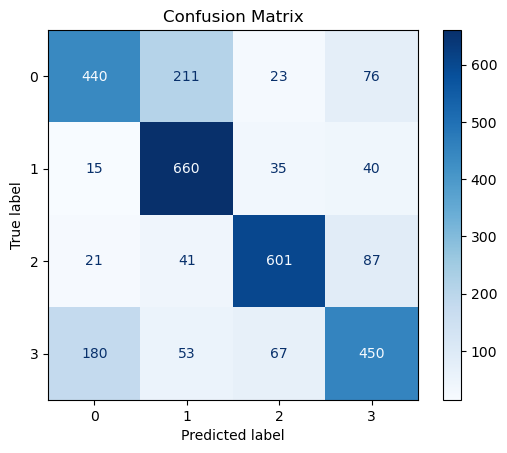

In [25]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()